In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
all_data = pd.read_csv('all_data.csv', index_col=0)
PM25 = pd.read_csv('PM25.csv', index_col=0)
model_data = all_data = pd.concat([all_data, PM25], axis=1)
model_data = model_data.rename(columns={model_data.columns[-1]: "PM2.5"})
model_data = model_data.dropna(subset=["PM2.5"])
model_data

X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002,random_state=42)

In [9]:
import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def objective(trial):
    X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
    y = model_data["PM2.5"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002, random_state=42)

    max_depth = trial.suggest_int('max_depth', 150, 300)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)

    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize')

improvement_threshold = 0.001
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 11000 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Najlepsze parametry:", best_params)
print("Najlepszy R^2 Score:", best_r2)


[I 2023-10-22 18:07:36,663] A new study created in memory with name: no-name-dc9f7324-f772-423c-a620-059106546a2e
[I 2023-10-22 18:07:36,679] Trial 0 finished with value: 0.919019124210266 and parameters: {'max_depth': 402, 'min_samples_split': 3, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.919019124210266.
[I 2023-10-22 18:07:36,694] Trial 1 finished with value: 0.923349864343909 and parameters: {'max_depth': 322, 'min_samples_split': 34, 'min_samples_leaf': 24}. Best is trial 1 with value: 0.923349864343909.
[I 2023-10-22 18:07:36,706] Trial 2 finished with value: 0.8959009908573481 and parameters: {'max_depth': 399, 'min_samples_split': 36, 'min_samples_leaf': 28}. Best is trial 1 with value: 0.923349864343909.
[I 2023-10-22 18:07:36,729] Trial 3 finished with value: 0.5712329869534856 and parameters: {'max_depth': 116, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.923349864343909.
[I 2023-10-22 18:07:36,743] Trial 4 finished with value: 0.

Najlepsze parametry: {'max_depth': 172, 'min_samples_split': 39, 'min_samples_leaf': 18}
Najlepszy R^2 Score: 0.9324602578013175


Średni błąd kwadratowy (MSE): 42.548277416786604
Procentowa zgodność: 93.25%


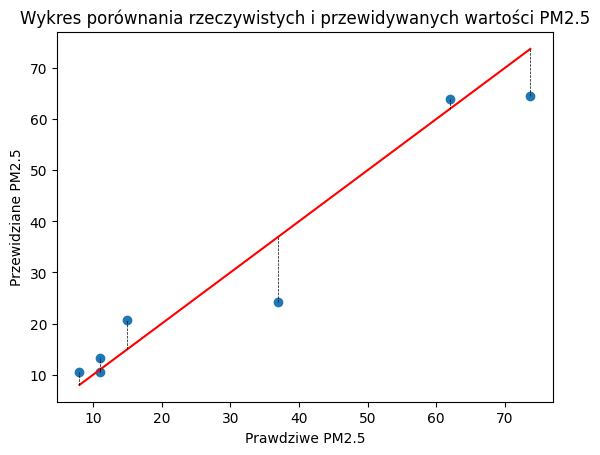

,Rzeczywiste wartości (y_test),Przewidywane wartości (y_pred),Różnica
0,11.00,13.189130,-2.189130
1,10.98,10.485909,0.494091
2,73.73,64.554400,9.175600
3,15.00,20.720927,-5.720927
4,8.00,10.485909,-2.485909
5,37.00,24.128889,12.871111
6,62.02,64.028889,-2.008889


In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


params =  {'max_depth': 172, 'min_samples_split': 39, 'min_samples_leaf': 18}
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine"]]
y = model_data["PM2.5"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002, random_state=42)


model = DecisionTreeRegressor(**params,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)']
results



